In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily

In [2]:
np.random.seed(0)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

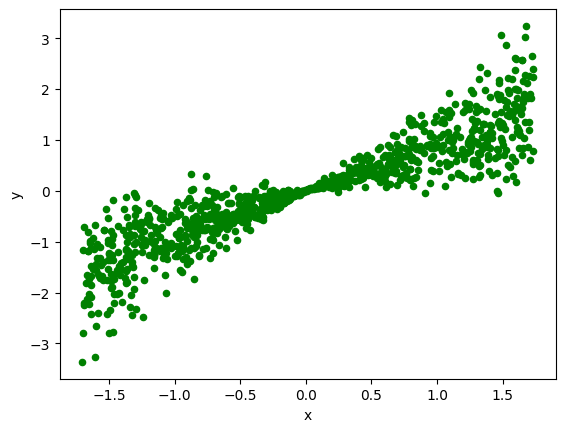

In [4]:
n = 1000
X = np.random.uniform(0, 10, size=(n, 1)).astype(np.float32)
y = (2 * X + 1 + np.random.normal(0, 1, size=(n, 1)) * (X - 5)).astype(
    np.float32
)  # Heteroscedasticity
#y = (2 * X + 1 + 3*np.random.normal(0, 1, size=(n, 1))).astype(
#    np.float32
#)  # Heteroscedasticity


X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

data = pd.DataFrame({"x": X.squeeze(), "y": y.squeeze()}).plot(
    kind="scatter", x="x", y="y", color="green"
);


In [43]:
def plot_credibility_interval(model, X, y, num_samples=50, fig=None, ax=None, y_min=-20, y_max=20):
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots()
    # Plot actual data
    X_np = X.detach().to(device="cpu").numpy()
    y_np = y.detach().to(device="cpu").numpy()
    scatter_actual = ax.scatter(X_np, y_np, color="green", label="Actual")

    sorting = X.detach().to(device="cpu").squeeze().sort()
    X_sorted = sorting.values.unsqueeze(1)

    predictions = []
    # Run multiple forward passes to get predictions for each input
    for _ in range(num_samples):
        y_hat_sample = model(X_sorted)[0]
        y_hat_np = y_hat_sample.to(device="cpu").detach().numpy().squeeze()
        predictions.append(y_hat_np)

    # Convert the predictions to a NumPy array for easier manipulation
    predictions = np.array(predictions)

    # Calculate mean and standard deviation across the samples
    y_hat_mean = predictions.mean(axis=0)
    y_hat_std = predictions.std(axis=0)

    # Calculate the 68.2% prediction interval (mean ± std)
    lower_bound = y_hat_mean - y_hat_std
    upper_bound = y_hat_mean + y_hat_std

    # Plot the prediction interval as a shaded region
    ax.fill_between(
        X_sorted.squeeze(-1),
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.6,
        label="68.2% Confidence Interval",
    )
    ax.plot(X_sorted.squeeze(-1), y_hat_mean, color="red")
    ax.set_ylim(y_min, y_max)
    return fig, ax


In [44]:
X_torch = torch.from_numpy(X).to(device=device)
y_torch = torch.from_numpy(y).squeeze().to(device=device)
print(X_torch.shape, y_torch.shape)

torch.Size([1000, 1]) torch.Size([1000])


In [45]:
class Layer(nn.Module):
    """
    A custom layer class for implementing a fully connected layer with
    Bayesian weights (reparameterized via `mu` and `rho`) and optional normalization.
    """

    def __init__(self, in_features, out_features, mu_mean=0, mu_std=1, rho_mean=-0.5, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.dtype = dtype if dtype is not None else torch.float32
        self.bias = bias

        # Parameters for the Bayesian layer (weights)
        self.mu_w = nn.Parameter(
            torch.normal(mu_mean, mu_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )
        self.rho_w = nn.Parameter(
            torch.normal(rho_mean, rho_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )

        if self.bias:
            self.mu_b = nn.Parameter(
                torch.normal(mu_mean, mu_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
            self.rho_b = nn.Parameter(
                torch.normal(rho_mean, rho_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
        else:
            self.mu_b = None
            self.rho_b = None
        
    @property
    def mu(self):
        mu_tensor = self.flatten(self.mu_w, self.mu_b)
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = self.flatten(self.rho_w, self.rho_b)
        return rho_tensor


    def num_params(self) -> int:
        # note number of network layer parameters is half this
        num = self.mu_w.numel() + self.rho_w.numel()
        if self.bias:
            num += self.mu_b.numel() + self.rho_b.numel()
        return int(num)

    def num_weights(self) -> int:
        return int(self.num_params()/2)

    def sample_weights(self):
        eps = torch.normal(
            0,
            1,
            self.mu_w.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_w))
        w = self.mu_w + sigma * eps
        return w

    def sample_bias(self):
        if not self.bias:
            return None
        eps = torch.normal(
            0,
            1,
            self.mu_b.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_b))
        b = self.mu_b + sigma * eps
        return b

    def sample(self):
        w = self.sample_weights()
        b = self.sample_bias()
        return w, b

    @staticmethod
    def flatten(weights, bias=None):
        if bias is not None:
            w = torch.cat([weights.flatten(), bias.flatten()])
        else:
            w = weights.flatten()
        return w
    
    def unflatten(self, weights: torch.Tensor):
        ws = self.mu_w.numel() # == self.mu_w.shape[0] * self.mu_w.shape[1]
        if self.bias:
            bs = self.mu_b.numel() # == self.mu_b.shape[0] * self.mu_b.shape[1]
            w, b = weights.split((ws, bs))
            w = w.reshape(self.mu_w.shape)
            b = b.reshape(self.mu_b.shape)
            return w, b

        else:
            w = weights.reshape(self.mu_w.shape)
            return w, None


    def forward(self, x):
        w, b = self.sample()
        y = x @ w.T
        if self.bias:
            y += b.T
        w = self.flatten(w, b)
        return y, w


class BayesNetwork(nn.Module):
    def __init__(self, num_input_features, num_output_features, mu_mean=0, mu_std=1, rho_mean=-1, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        hidden_dim = 8
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        self.device = device
        self.dtype = dtype

        # Define the layers in the network
        self.layer1 = Layer(
            num_input_features,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer2 = Layer(
            hidden_dim,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer3 = Layer(
            hidden_dim,
            num_output_features,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )

    @property
    def mu(self):
        mu_tensor = torch.cat([self.layer1.mu, self.layer2.mu, self.layer3.mu])
        return mu_tensor

    @property
    def rho(self):
        rho_tensor = torch.cat([self.layer1.rho, self.layer2.rho, self.layer3.rho])
        return rho_tensor

    def forward(self, x):
        x = x.to(dtype=self.dtype, device=self.device)

        # Pass through the layers
        a1, w1 = self.layer1(x)
        z1 = F.tanh(a1)
        a2, w2 = self.layer2(z1)
        z2 = F.tanh(a2)
        x3, w3 = self.layer3(z2)

        params = [w1, w2, w3]
        w = torch.cat(params)

        return x3.squeeze(-1), w

    def num_weights(self):
        return self.layer1.num_weights() + self.layer2.num_weights() + self.layer3.num_weights()


# Example usage:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#num_input_features = 1 
#num_output_features = 1
#bias = True
#dtype = torch.float32
#
#
## Create the Bayesian network model
#model = BayesNetwork(num_input_features, num_output_features, device=device, bias=bias, dtype=dtype)
##model = Layer(1, 1, rho_std, device, bias, dtype)
#
## Forward pass
#_, _ = model(X_torch)

In [46]:
def train_with_constant_lr(model, epochs=600, lr=1.0, is_linear=False):
    num_eps_samples = 1 # number of samples to average the loss over
    batch_size = 1000

    optimizer = Adam(model.parameters(), lr=lr)

    model.to(device=device)
    model.train()
    fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        if is_linear:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
            )
        else:
            print(f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}")
        if (epoch+1) % 20 == 0:
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=True)
            print()
        plt.show()

    fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [47]:
def train_with_lr_reducer(model, epochs=600, batch_size=1000, lr_start=1.0, is_linear=False):
    num_eps_samples = 50 # number of samples to average the loss over
    lr = lr_start
    optimizer = Adam(model.parameters(), lr=lr)
    lr_reducer = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    model.to(device=device)
    model.train()
    fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        lr_reducer.step(loss)
        if is_linear:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr_reducer.get_last_lr()[0]:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
            )
        else:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}"
            )
        if (epoch+1) % 20 == 0:
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=True)
            print()
        plt.show()

    fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [48]:
def create_gmm(num_params, sigmas, weights, device=device):
    """
    Creates a Gaussian Mixture Model (GMM) of multivariate normal of size num_params with mean 0 and standard deviations provided by sigmas.

    Args:
        num_params (int): The number of parameters.
        sigmas (list of float): Standard deviations for the Gaussian components.
        weights (list of float): Mixture weights for each component, should sum to 1.

    Returns:
        MixtureSameFamily: A Gaussian Mixture Model distribution with multivariate normal components.
        sum(i=1...len(sigmas)) weight[i] * N(0, sigma[i])

    Example:
        >>> w = torch.cat([param.flatten() for param in model.parameters()])
        >>> p_w = create_gmm(w.shape[0], (1.0, 0.1), (0.75, 0.25))
        >>> p_w.log_prob(w)
        tensor(1402409.1250, grad_fn=<LogsumexpBackward0>)
    """

    num_mixtures = len(sigmas)
    means = torch.zeros(
        (num_mixtures, num_params), device=device
    )  # Shape: (num_mixtures, num_params)

    # Create diagonal standard deviations for each component based on sigmas
    stds = torch.stack(
        [torch.ones(num_params, device=device) * sigma for sigma in sigmas],
    )  # Shape: (num_mixtures, num_params)

    # Use Normal + Independence instead of MultivariateNormal to prevent too many non-sparse covariance matrices
    normal_dists = Normal(means, stds)  # Shape: (num_mixtures, num_params)

    # Treat columns as different independent events to collapse across columns (1)
    independent_dists = Independent(
        normal_dists, 1
    ) # (num_mixtures,)

    # Define the categorical distribution over components with specified weights
    cat = Categorical(torch.tensor(weights, device=device))

    # Create the Gaussian Mixture Model
    gmm = MixtureSameFamily(cat, independent_dists)

    return gmm


In [54]:

def get_variational_pdf(mu, rho):
    # Compute sigma as before
    sigma = torch.log(1 + torch.exp(rho))

    # Define independent Normal distributions for each num_paramsension
    q_theta = D.Independent(D.Normal(mu, sigma), 1)

    return q_theta


def loss_fn(y_hat, y, w, mu, rho, kl_weight=1.0, verbose=False):
    q_theta = get_variational_pdf(mu, rho)
    p_w = create_gmm(len(w), (0.75, 0.1), (0.25, 0.75))

    q_theta_loss = q_theta.log_prob(w)
    p_w_neg_loss = p_w.log_prob(w)
    kl_loss = (q_theta_loss - p_w_neg_loss)
    log_likelihood_loss = -0.5 * nn.MSELoss(reduction="sum")(y_hat, y) # assumes Id covariance matrix
    nll_loss = - log_likelihood_loss
    loss = (nll_loss + kl_weight * kl_loss)
    if verbose:
        print(
            f"Loss: {loss.detach().to(device='cpu').item()}| nll: {nll_loss.detach().to(device='cpu').item()}| kl: {kl_loss.detach().to(device='cpu').item()} (weight: {kl_weight:.2f}) = {q_theta_loss.detach().to(device='cpu').item()} (variational) - {p_w_neg_loss.detach().to(device='cpu').item()} (prior)"
        )
    return loss


def get_kl_weight(epoch, epochs):
    # exponential growth
    # This grows more slowly at the start and levels off near 1 as epoch approaches epochs.
    kl_weight = 1 - np.exp(-epoch / (epochs * 0.1))
    kl_weight = 1
    return kl_weight

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_input_features = 1
num_output_features = 1
bias = True
dtype = torch.float32

mu_mean, mu_std = (0, 1.0)
rho_mean, rho_std = (-1, 0.1)

# Create the Bayesian network model
model = BayesNetwork(
    num_input_features, num_output_features, mu_mean=mu_mean, mu_std=mu_std, rho_mean=rho_mean, rho_std=rho_std, device=device, bias=bias, dtype=dtype
)


# Forward pass
_, _ = model(X_torch)


# prior

# p_w = create_gmm(model.num_weights(), (1, 0.1), (0.25, 0.75))

epoch=1/200 | lr=1 | loss=3510.8759765625 | ||mu|| = 12.89 | ||rho|| = 13.52


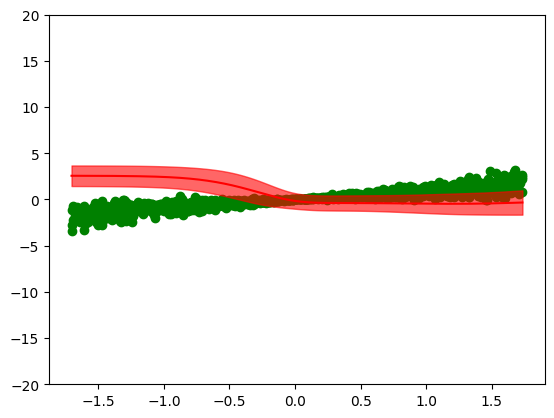

epoch=2/200 | lr=1 | loss=2736.230224609375 | ||mu|| = 17.11 | ||rho|| = 17.89
epoch=3/200 | lr=1 | loss=7599.84228515625 | ||mu|| = 20.26 | ||rho|| = 21.25
epoch=4/200 | lr=1 | loss=1274.2301025390625 | ||mu|| = 23.12 | ||rho|| = 23.86
epoch=5/200 | lr=1 | loss=3680.8486328125 | ||mu|| = 25.50 | ||rho|| = 25.92
epoch=6/200 | lr=1 | loss=2596.095703125 | ||mu|| = 27.63 | ||rho|| = 27.63
epoch=7/200 | lr=1 | loss=1718.373046875 | ||mu|| = 29.54 | ||rho|| = 28.91
epoch=8/200 | lr=1 | loss=2520.15673828125 | ||mu|| = 31.19 | ||rho|| = 29.85
epoch=9/200 | lr=1 | loss=2802.24951171875 | ||mu|| = 32.65 | ||rho|| = 30.53
epoch=10/200 | lr=1 | loss=1746.9737548828125 | ||mu|| = 33.90 | ||rho|| = 30.99
epoch=11/200 | lr=1 | loss=1954.4913330078125 | ||mu|| = 34.92 | ||rho|| = 31.28
epoch=12/200 | lr=1 | loss=2483.387939453125 | ||mu|| = 35.73 | ||rho|| = 31.38
epoch=13/200 | lr=1 | loss=2056.159912109375 | ||mu|| = 36.35 | ||rho|| = 31.41
epoch=14/200 | lr=1 | loss=1709.720947265625 | ||mu|| = 

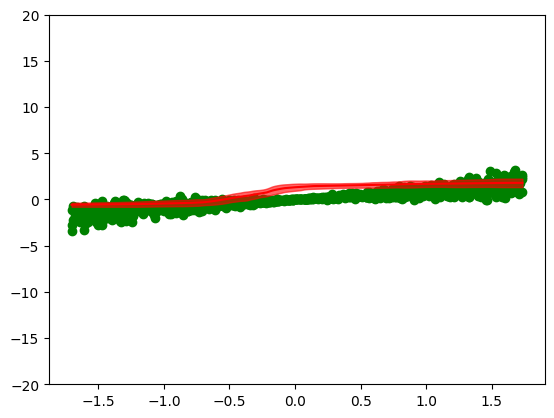

epoch=21/200 | lr=1 | loss=1939.1666259765625 | ||mu|| = 36.77 | ||rho|| = 30.55
epoch=22/200 | lr=1 | loss=1821.239990234375 | ||mu|| = 36.55 | ||rho|| = 30.27
epoch=23/200 | lr=1 | loss=1656.3287353515625 | ||mu|| = 36.29 | ||rho|| = 29.97
epoch=24/200 | lr=1 | loss=1532.2803955078125 | ||mu|| = 36.00 | ||rho|| = 29.65
epoch=25/200 | lr=1 | loss=1571.5697021484375 | ||mu|| = 35.68 | ||rho|| = 29.33
epoch=26/200 | lr=1 | loss=1629.1871337890625 | ||mu|| = 35.33 | ||rho|| = 29.00
epoch=27/200 | lr=1 | loss=1601.1925048828125 | ||mu|| = 35.14 | ||rho|| = 28.84
epoch=28/200 | lr=1 | loss=1526.9661865234375 | ||mu|| = 34.95 | ||rho|| = 28.68
epoch=29/200 | lr=1 | loss=1464.103515625 | ||mu|| = 34.73 | ||rho|| = 28.51
epoch=30/200 | lr=1 | loss=1424.3197021484375 | ||mu|| = 34.52 | ||rho|| = 28.34
epoch=31/200 | lr=1 | loss=1393.855712890625 | ||mu|| = 34.29 | ||rho|| = 28.17
epoch=32/200 | lr=1 | loss=1413.517333984375 | ||mu|| = 34.05 | ||rho|| = 27.99
epoch=33/200 | lr=1 | loss=1415.577

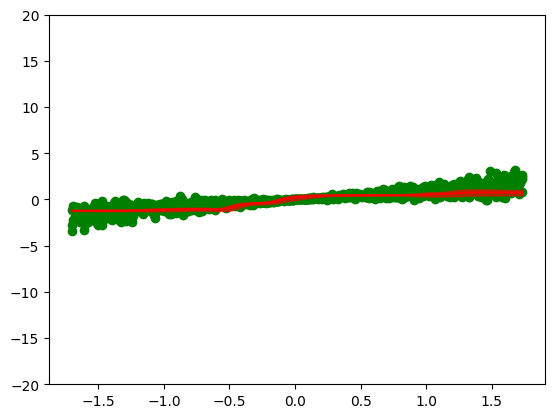

epoch=41/200 | lr=1 | loss=1255.2535400390625 | ||mu|| = 32.28 | ||rho|| = 26.69
epoch=42/200 | lr=1 | loss=1228.4798583984375 | ||mu|| = 32.14 | ||rho|| = 26.59
epoch=43/200 | lr=1 | loss=1214.898193359375 | ||mu|| = 32.00 | ||rho|| = 26.49
epoch=44/200 | lr=1 | loss=1214.0887451171875 | ||mu|| = 31.86 | ||rho|| = 26.39
epoch=45/200 | lr=1 | loss=1205.3787841796875 | ||mu|| = 31.72 | ||rho|| = 26.29
epoch=46/200 | lr=1 | loss=1181.7537841796875 | ||mu|| = 31.57 | ||rho|| = 26.19
epoch=47/200 | lr=1 | loss=1168.92041015625 | ||mu|| = 31.43 | ||rho|| = 26.09
epoch=48/200 | lr=1 | loss=1164.0823974609375 | ||mu|| = 31.28 | ||rho|| = 25.99
epoch=49/200 | lr=1 | loss=1139.9556884765625 | ||mu|| = 31.14 | ||rho|| = 25.89
epoch=50/200 | lr=1 | loss=1134.7310791015625 | ||mu|| = 30.99 | ||rho|| = 25.79
epoch=51/200 | lr=1 | loss=1133.2186279296875 | ||mu|| = 30.84 | ||rho|| = 25.68
epoch=52/200 | lr=1 | loss=1126.0506591796875 | ||mu|| = 30.70 | ||rho|| = 25.58
epoch=53/200 | lr=1 | loss=1112

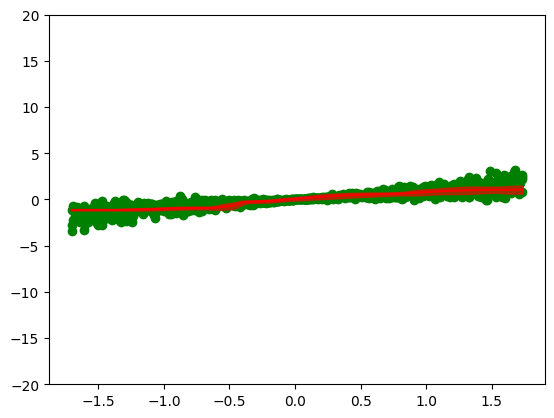

epoch=61/200 | lr=1 | loss=1034.0916748046875 | ||mu|| = 29.37 | ||rho|| = 24.67
epoch=62/200 | lr=1 | loss=1013.9678955078125 | ||mu|| = 29.22 | ||rho|| = 24.57
epoch=63/200 | lr=1 | loss=1022.8048706054688 | ||mu|| = 29.08 | ||rho|| = 24.48
epoch=64/200 | lr=1 | loss=1009.1214599609375 | ||mu|| = 28.93 | ||rho|| = 24.38
epoch=65/200 | lr=1 | loss=1005.1367797851562 | ||mu|| = 28.78 | ||rho|| = 24.28
epoch=66/200 | lr=1 | loss=982.2483520507812 | ||mu|| = 28.64 | ||rho|| = 24.19
epoch=67/200 | lr=1 | loss=976.2916259765625 | ||mu|| = 28.49 | ||rho|| = 24.09
epoch=68/200 | lr=1 | loss=965.0892944335938 | ||mu|| = 28.35 | ||rho|| = 24.00
epoch=69/200 | lr=1 | loss=955.323974609375 | ||mu|| = 28.20 | ||rho|| = 23.91
epoch=70/200 | lr=1 | loss=950.8087158203125 | ||mu|| = 28.06 | ||rho|| = 23.81
epoch=71/200 | lr=1 | loss=939.3967895507812 | ||mu|| = 27.91 | ||rho|| = 23.72
epoch=72/200 | lr=1 | loss=938.337890625 | ||mu|| = 27.77 | ||rho|| = 23.63
epoch=73/200 | lr=1 | loss=921.888549804

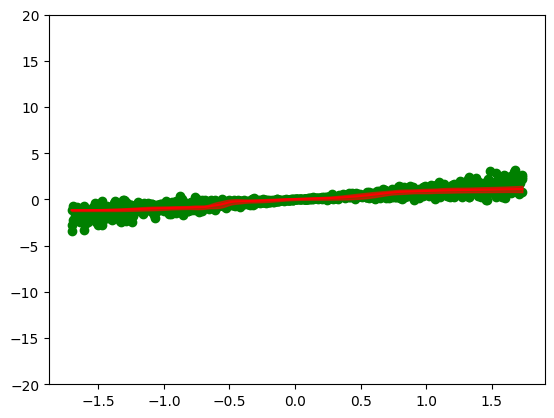

epoch=81/200 | lr=1 | loss=859.2149658203125 | ||mu|| = 26.50 | ||rho|| = 22.81
epoch=82/200 | lr=1 | loss=844.867431640625 | ||mu|| = 26.36 | ||rho|| = 22.72
epoch=83/200 | lr=1 | loss=844.2718505859375 | ||mu|| = 26.23 | ||rho|| = 22.63
epoch=84/200 | lr=1 | loss=838.2113037109375 | ||mu|| = 26.09 | ||rho|| = 22.55
epoch=85/200 | lr=1 | loss=832.145263671875 | ||mu|| = 25.95 | ||rho|| = 22.46
epoch=86/200 | lr=1 | loss=814.3490600585938 | ||mu|| = 25.82 | ||rho|| = 22.38
epoch=87/200 | lr=1 | loss=820.1881713867188 | ||mu|| = 25.68 | ||rho|| = 22.29
epoch=88/200 | lr=1 | loss=811.6571655273438 | ||mu|| = 25.55 | ||rho|| = 22.20
epoch=89/200 | lr=1 | loss=799.0126342773438 | ||mu|| = 25.42 | ||rho|| = 22.12
epoch=90/200 | lr=1 | loss=799.6585693359375 | ||mu|| = 25.28 | ||rho|| = 22.03
epoch=91/200 | lr=1 | loss=786.31982421875 | ||mu|| = 25.15 | ||rho|| = 21.95
epoch=92/200 | lr=1 | loss=778.6276245117188 | ||mu|| = 25.02 | ||rho|| = 21.86
epoch=93/200 | lr=1 | loss=771.2760009765625

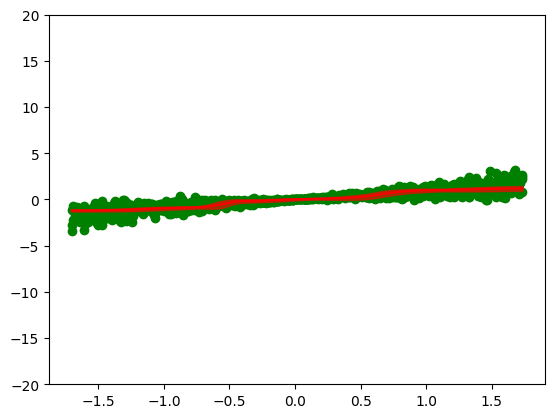

epoch=101/200 | lr=1 | loss=729.6956176757812 | ||mu|| = 23.85 | ||rho|| = 21.09
epoch=102/200 | lr=1 | loss=721.6719360351562 | ||mu|| = 23.73 | ||rho|| = 21.00
epoch=103/200 | lr=1 | loss=708.3540649414062 | ||mu|| = 23.60 | ||rho|| = 20.92
epoch=104/200 | lr=1 | loss=704.4483642578125 | ||mu|| = 23.48 | ||rho|| = 20.84
epoch=105/200 | lr=1 | loss=704.242431640625 | ||mu|| = 23.35 | ||rho|| = 20.76
epoch=106/200 | lr=1 | loss=698.0790405273438 | ||mu|| = 23.23 | ||rho|| = 20.67
epoch=107/200 | lr=1 | loss=698.6738891601562 | ||mu|| = 23.10 | ||rho|| = 20.60
epoch=108/200 | lr=1 | loss=688.1143798828125 | ||mu|| = 22.98 | ||rho|| = 20.52
epoch=109/200 | lr=1 | loss=676.519775390625 | ||mu|| = 22.86 | ||rho|| = 20.44
epoch=110/200 | lr=1 | loss=677.3329467773438 | ||mu|| = 22.74 | ||rho|| = 20.37
epoch=111/200 | lr=1 | loss=672.3848876953125 | ||mu|| = 22.62 | ||rho|| = 20.29
epoch=112/200 | lr=1 | loss=666.8833618164062 | ||mu|| = 22.50 | ||rho|| = 20.22
epoch=113/200 | lr=1 | loss=65

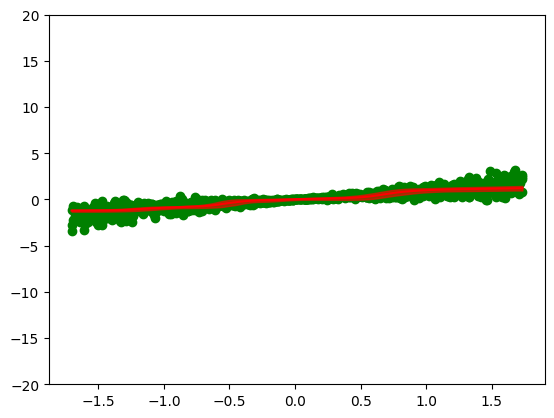

epoch=121/200 | lr=1 | loss=611.837158203125 | ||mu|| = 21.45 | ||rho|| = 19.58
epoch=122/200 | lr=1 | loss=616.4207763671875 | ||mu|| = 21.34 | ||rho|| = 19.51
epoch=123/200 | lr=1 | loss=606.2399291992188 | ||mu|| = 21.23 | ||rho|| = 19.44
epoch=124/200 | lr=1 | loss=602.8660278320312 | ||mu|| = 21.11 | ||rho|| = 19.38
epoch=125/200 | lr=1 | loss=599.656005859375 | ||mu|| = 21.00 | ||rho|| = 19.31
epoch=126/200 | lr=1 | loss=593.414306640625 | ||mu|| = 20.89 | ||rho|| = 19.24
epoch=127/200 | lr=1 | loss=589.6569213867188 | ||mu|| = 20.78 | ||rho|| = 19.18
epoch=128/200 | lr=1 | loss=576.533447265625 | ||mu|| = 20.67 | ||rho|| = 19.11
epoch=129/200 | lr=1 | loss=580.5029296875 | ||mu|| = 20.56 | ||rho|| = 19.04
epoch=130/200 | lr=1 | loss=579.5404663085938 | ||mu|| = 20.45 | ||rho|| = 18.98
epoch=131/200 | lr=1 | loss=567.3901977539062 | ||mu|| = 20.34 | ||rho|| = 18.92
epoch=132/200 | lr=1 | loss=573.3367919921875 | ||mu|| = 20.24 | ||rho|| = 18.86
epoch=133/200 | lr=1 | loss=564.849

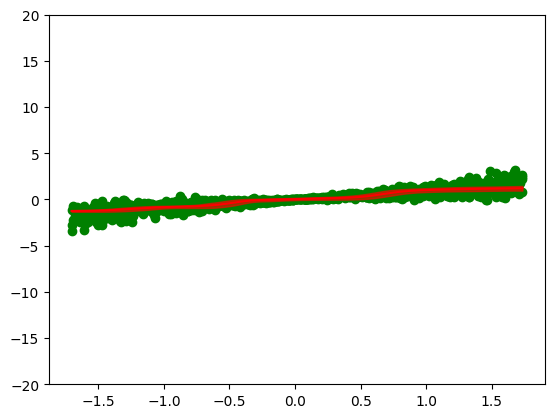

epoch=141/200 | lr=1 | loss=532.3882446289062 | ||mu|| = 19.31 | ||rho|| = 18.33
epoch=142/200 | lr=1 | loss=527.3470458984375 | ||mu|| = 19.21 | ||rho|| = 18.29
epoch=143/200 | lr=1 | loss=519.9069213867188 | ||mu|| = 19.11 | ||rho|| = 18.23
epoch=144/200 | lr=1 | loss=514.5370483398438 | ||mu|| = 19.01 | ||rho|| = 18.18
epoch=145/200 | lr=1 | loss=515.4663696289062 | ||mu|| = 18.91 | ||rho|| = 18.13
epoch=146/200 | lr=1 | loss=514.3157958984375 | ||mu|| = 18.82 | ||rho|| = 18.08
epoch=147/200 | lr=1 | loss=511.5925598144531 | ||mu|| = 18.72 | ||rho|| = 18.03
epoch=148/200 | lr=1 | loss=511.0599060058594 | ||mu|| = 18.62 | ||rho|| = 17.98
epoch=149/200 | lr=1 | loss=501.7643737792969 | ||mu|| = 18.53 | ||rho|| = 17.93
epoch=150/200 | lr=1 | loss=497.9174499511719 | ||mu|| = 18.43 | ||rho|| = 17.88
epoch=151/200 | lr=1 | loss=491.96490478515625 | ||mu|| = 18.33 | ||rho|| = 17.83
epoch=152/200 | lr=1 | loss=492.8130798339844 | ||mu|| = 18.24 | ||rho|| = 17.78
epoch=153/200 | lr=1 | loss

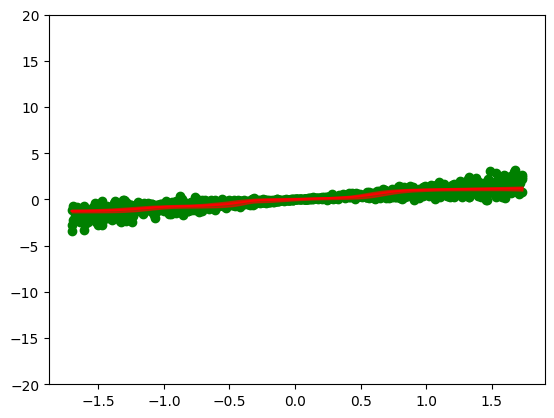

epoch=161/200 | lr=1 | loss=466.5369567871094 | ||mu|| = 17.41 | ||rho|| = 17.39
epoch=162/200 | lr=1 | loss=459.52093505859375 | ||mu|| = 17.33 | ||rho|| = 17.34
epoch=163/200 | lr=1 | loss=452.3753356933594 | ||mu|| = 17.24 | ||rho|| = 17.29
epoch=164/200 | lr=1 | loss=449.5561218261719 | ||mu|| = 17.15 | ||rho|| = 17.25
epoch=165/200 | lr=1 | loss=450.74371337890625 | ||mu|| = 17.06 | ||rho|| = 17.20
epoch=166/200 | lr=1 | loss=445.7244567871094 | ||mu|| = 16.97 | ||rho|| = 17.15
epoch=167/200 | lr=1 | loss=439.9523010253906 | ||mu|| = 16.88 | ||rho|| = 17.11
epoch=168/200 | lr=1 | loss=440.6761474609375 | ||mu|| = 16.80 | ||rho|| = 17.06
epoch=169/200 | lr=1 | loss=440.5072021484375 | ||mu|| = 16.71 | ||rho|| = 17.01
epoch=170/200 | lr=1 | loss=432.9937438964844 | ||mu|| = 16.62 | ||rho|| = 16.97
epoch=171/200 | lr=1 | loss=430.80377197265625 | ||mu|| = 16.53 | ||rho|| = 16.92
epoch=172/200 | lr=1 | loss=430.2356872558594 | ||mu|| = 16.45 | ||rho|| = 16.87
epoch=173/200 | lr=1 | lo

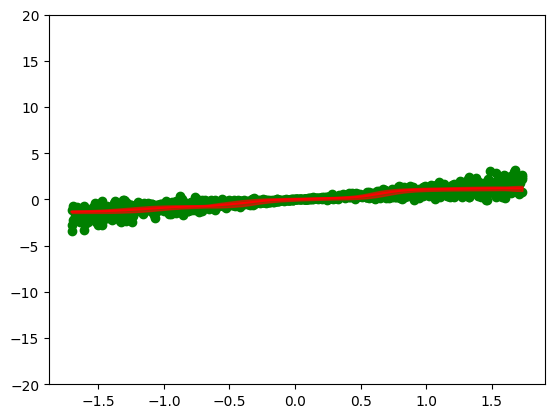

epoch=181/200 | lr=1 | loss=413.9211120605469 | ||mu|| = 15.71 | ||rho|| = 16.58
epoch=182/200 | lr=1 | loss=408.30517578125 | ||mu|| = 15.63 | ||rho|| = 16.55
epoch=183/200 | lr=1 | loss=406.84478759765625 | ||mu|| = 15.55 | ||rho|| = 16.53
epoch=184/200 | lr=1 | loss=393.9341735839844 | ||mu|| = 15.47 | ||rho|| = 16.51
epoch=185/200 | lr=1 | loss=399.8098449707031 | ||mu|| = 15.39 | ||rho|| = 16.48
epoch=186/200 | lr=1 | loss=393.5597839355469 | ||mu|| = 15.32 | ||rho|| = 16.46
epoch=187/200 | lr=1 | loss=390.8898620605469 | ||mu|| = 15.24 | ||rho|| = 16.43
epoch=188/200 | lr=1 | loss=395.53656005859375 | ||mu|| = 15.16 | ||rho|| = 16.41
epoch=189/200 | lr=1 | loss=390.2449035644531 | ||mu|| = 15.09 | ||rho|| = 16.38
epoch=190/200 | lr=1 | loss=381.98931884765625 | ||mu|| = 15.01 | ||rho|| = 16.35
epoch=191/200 | lr=1 | loss=382.9625244140625 | ||mu|| = 14.94 | ||rho|| = 16.33
epoch=192/200 | lr=1 | loss=384.1775207519531 | ||mu|| = 14.86 | ||rho|| = 16.30
epoch=193/200 | lr=1 | loss

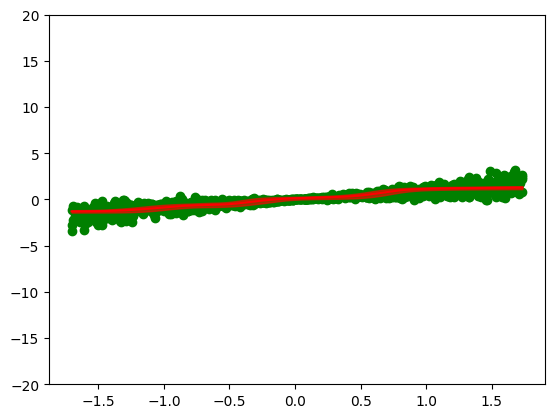

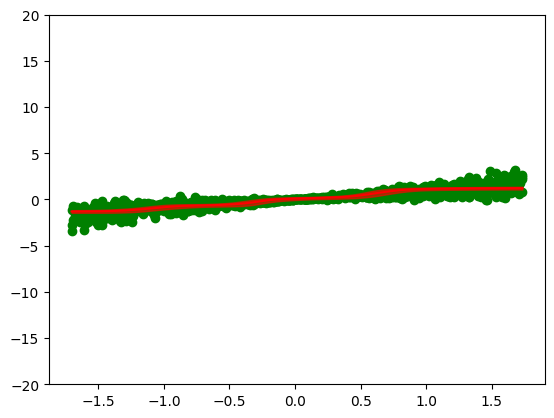

In [56]:
train_with_lr_reducer(model, batch_size=1000, lr_start=1, epochs=200)

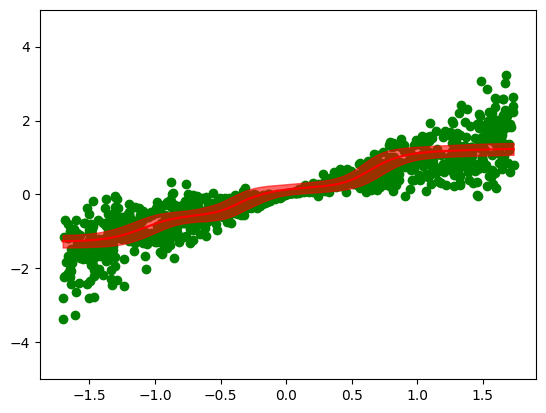

In [57]:
plot_credibility_interval(model, X_torch, y_torch, y_min=-5, y_max=5, num_samples=100);